In [ ]:
!pip install opencv-python pillow numpy matplotlib scikit-image

In [ ]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage.filters import threshold_otsu

from google.colab import files

plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["axes.axisbelow"] = True

def show(img, cmap="gray", title=None):
    plt.figure()
    if img.ndim == 2:
        plt.imshow(img, cmap=cmap)
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()

Saving floor-plan-sample-3.webp to floor-plan-sample-3.webp
Loaded: floor-plan-sample-3.webp, shape: (1683, 2500, 3)


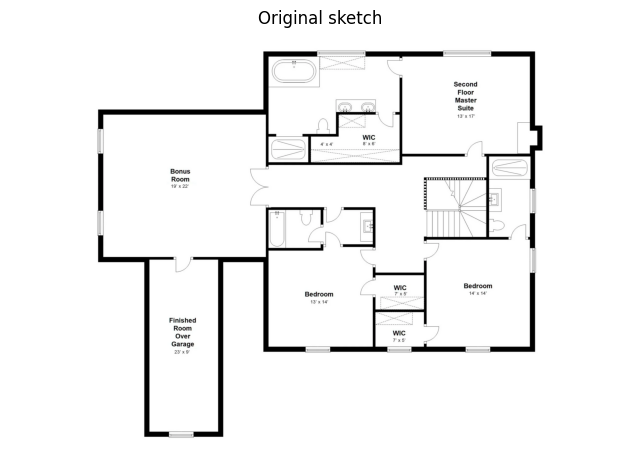

In [ ]:
def upload_image():
    uploaded = files.upload()
    if not uploaded:
        return None, None
    name = list(uploaded.keys())[0]
    pil_img = Image.open(name).convert("RGB")
    img = np.array(pil_img)
    print(f"Loaded: {name}, shape: {img.shape}")
    show(img, title="Original sketch")
    return img, name

raw_img, raw_name = upload_image()

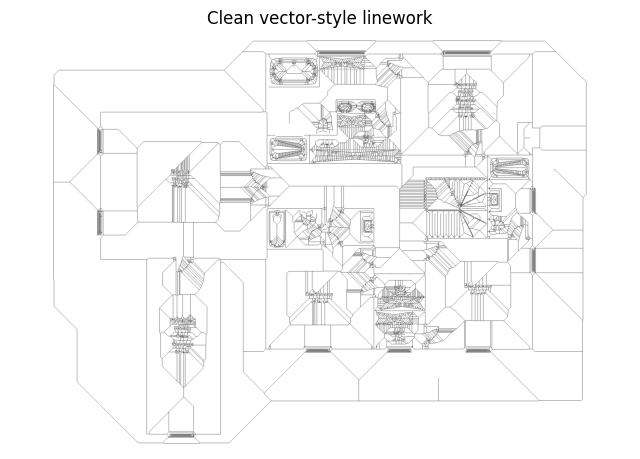

In [ ]:
def to_clean_linework(img, blur_ksize=3, canny1=50, canny2=150):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (blur_ksize, blur_ksize), 0)
    edges = cv2.Canny(blur, canny1, canny2)

    # Invert for skeletonization
    inv = 255 - edges
    thresh_val = threshold_otsu(inv)
    binary = inv > thresh_val
    skel = skeletonize(binary).astype(np.uint8) * 255

    # Clean linework on white background
    clean = np.full_like(gray, 255)
    clean[skel > 0] = 0
    clean_rgb = cv2.cvtColor(clean, cv2.COLOR_GRAY2RGB)
    return clean_rgb

clean_img = to_clean_linework(raw_img)
show(clean_img, title="Clean vector-style linework")

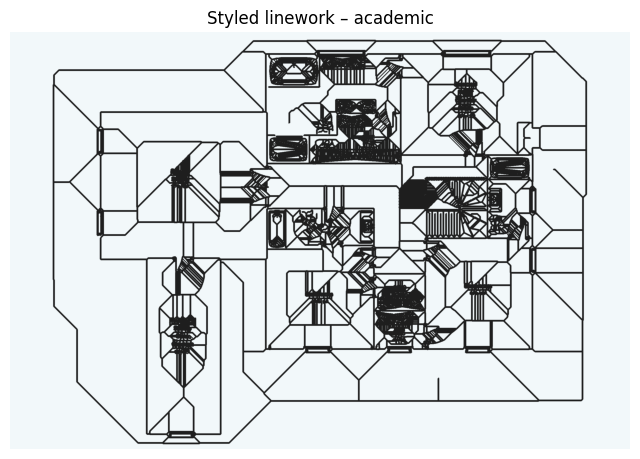

In [ ]:
STYLE_MODES = {
    "minimalist": {"bg": (255, 255, 255), "line": (0, 0, 0), "thickness": 1},
    "academic": {"bg": (250, 248, 242), "line": (30, 30, 30), "thickness": 2},
    "competition": {"bg": (255, 255, 255), "line": (10, 10, 10), "thickness": 3},
    "playful": {"bg": (255, 252, 240), "line": (40, 40, 40), "thickness": 2},
    "monochrome": {"bg": (240, 240, 240), "line": (20, 20, 20), "thickness": 2},
}

def apply_style(clean_img, mode="academic"):
    params = STYLE_MODES.get(mode, STYLE_MODES["academic"])
    gray = cv2.cvtColor(clean_img, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 10, 100)

    h, w = gray.shape
    styled = np.full((h, w, 3), params["bg"], dtype=np.uint8)
    ys, xs = np.where(edges > 0)
    for y, x in zip(ys, xs):
        cv2.circle(styled, (x, y), params["thickness"] // 2 + 1, params["line"], -1)

    return styled

styled_img = apply_style(clean_img, mode="academic")
show(styled_img, title="Styled linework – academic")

In [ ]:
COLOR_PALETTES = {
    "modern_arch": {
        "charcoal": (40, 40, 40),
        "sand": (214, 198, 170),
        "rust": (170, 90, 60),
        "sage": (160, 178, 150),
        "ultramarine": (40, 70, 140),
    },
    "competition": {
        "black": (10, 10, 10),
        "neon_yellow": (230, 230, 40),
        "neon_pink": (230, 60, 140),
        "cyan": (40, 200, 220),
    },
    "editorial_soft": {
        "ink": (30, 30, 40),
        "cream": (245, 240, 230),
        "dusty_rose": (200, 150, 150),
        "pale_blue": (190, 205, 220),
    },
}

def get_palette(name="modern_arch"):
    return COLOR_PALETTES.get(name, COLOR_PALETTES["modern_arch"])

print("Available palettes:", list(COLOR_PALETTES.keys()))
print("Modern arch palette:", get_palette("modern_arch"))

Available palettes: ['modern_arch', 'competition', 'editorial_soft']
Modern arch palette: {'charcoal': (40, 40, 40), 'sand': (214, 198, 170), 'rust': (170, 90, 60), 'sage': (160, 178, 150), 'ultramarine': (40, 70, 140)}


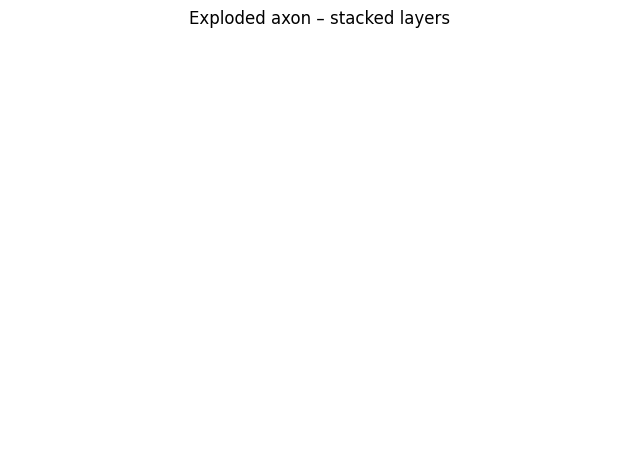

In [ ]:
def exploded_axon(base_img, layers=3, offset=(20, -15), palette_name="modern_arch", alpha_step=0.25):
    h, w, _ = base_img.shape
    canvas = np.full_like(base_img, 255)
    palette = list(get_palette(palette_name).values())

    for i in range(layers):
        dx = int(offset[0] * i)
        dy = int(offset[1] * i)
        color = palette[i % len(palette)]

        tinted = base_img.copy()
        mask = cv2.cvtColor(base_img, cv2.COLOR_RGB2GRAY) < 250
        tinted[mask] = color

        M = np.float32([[1, 0, dx], [0, 1, dy]])
        shifted = cv2.warpAffine(tinted, M, (w, h), borderValue=(255, 255, 255))

        alpha = 1.0 - i * alpha_step
        alpha = max(alpha, 0.1)
        canvas = cv2.addWeighted(canvas, 1.0, shifted, alpha, 0)

    return canvas

axon_img = exploded_axon(styled_img, layers=4, offset=(25, -18), palette_name="modern_arch")
show(axon_img, title="Exploded axon – stacked layers")

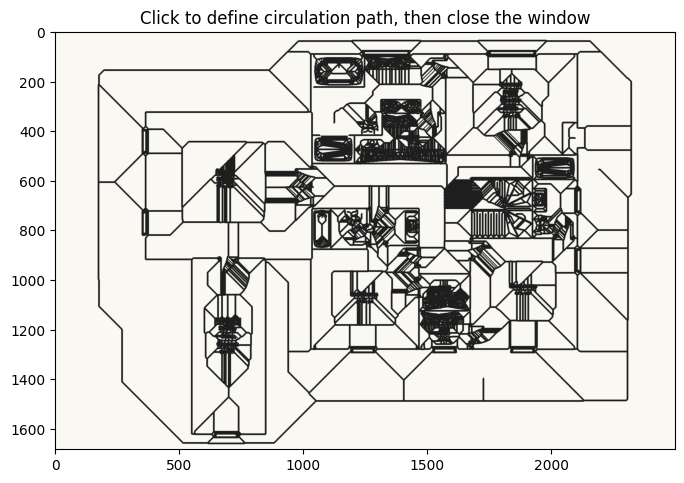

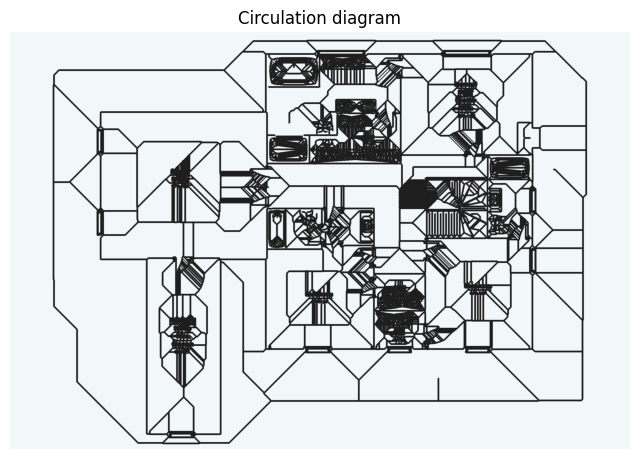

In [ ]:
from matplotlib.widgets import Button

click_points = []

def onclick(event):
    if event.xdata is None or event.ydata is None:
        return
    click_points.append((int(event.xdata), int(event.ydata)))
    plt.scatter(event.xdata, event.ydata, c="red", s=20)
    plt.draw()

def collect_path_points(img):
    global click_points
    click_points = []

    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.set_title("Click to define circulation path, then close the window")
    cid = fig.canvas.mpl_connect("button_press_event", onclick)
    plt.show()
    fig.canvas.mpl_disconnect(cid)
    return click_points

def draw_circulation(img, points, color=(230, 60, 140), thickness=4, arrow_every=40):
    circ = img.copy()
    if len(points) < 2:
        return circ

    for i in range(len(points) - 1):
        cv2.line(circ, points[i], points[i + 1], color, thickness, cv2.LINE_AA)

    # Simple arrows along the path
    for i in range(0, len(points) - 1, max(1, len(points) // 5)):
        p1 = np.array(points[i], dtype=np.float32)
        p2 = np.array(points[i + 1], dtype=np.float32)
        v = p2 - p1
        if np.linalg.norm(v) < 1:
            continue
        v = v / np.linalg.norm(v)
        base = p1 + v * arrow_every
        left = base + np.array([-v[1], v[0]]) * 6
        right = base + np.array([v[1], -v[0]]) * 6
        pts = np.array([base, left, right], dtype=np.int32)
        cv2.fillConvexPoly(circ, pts, color)

    return circ

# Collect path on top of styled_img
path_points = collect_path_points(styled_img)
circ_img = draw_circulation(styled_img, path_points, color=get_palette("competition")["neon_pink"])
show(circ_img, title="Circulation diagram")

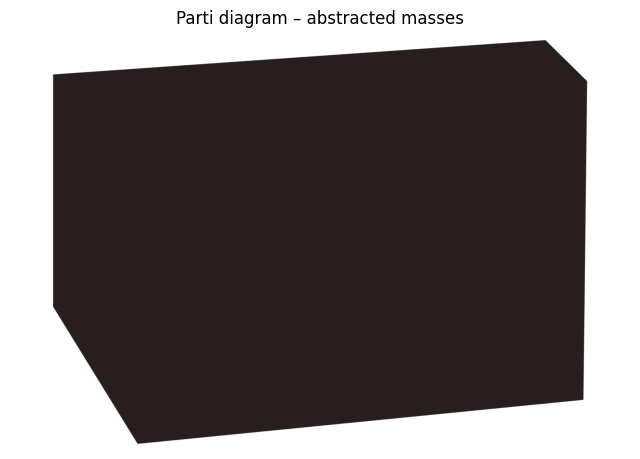

In [ ]:
def parti_from_image(img, blur_ksize=9, block_size=51, C=10, min_area=200):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (blur_ksize, blur_ksize), 0)
    thresh = cv2.adaptiveThreshold(
        blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, block_size, C
    )

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    parti = np.full_like(img, 255)
    palette = get_palette("editorial_soft")
    fill_colors = list(palette.values())
    outline_color = palette["ink"]

    idx = 0
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < min_area:
            continue
        epsilon = 0.02 * cv2.arcLength(cnt, True)
        approx = cv2.approxPolyDP(cnt, epsilon, True)
        color = fill_colors[idx % len(fill_colors)]
        cv2.fillPoly(parti, [approx], color)
        cv2.polylines(parti, [approx], True, outline_color, 2, cv2.LINE_AA)
        idx += 1

    return parti

parti_img = parti_from_image(clean_img)
show(parti_img, title="Parti diagram – abstracted masses")

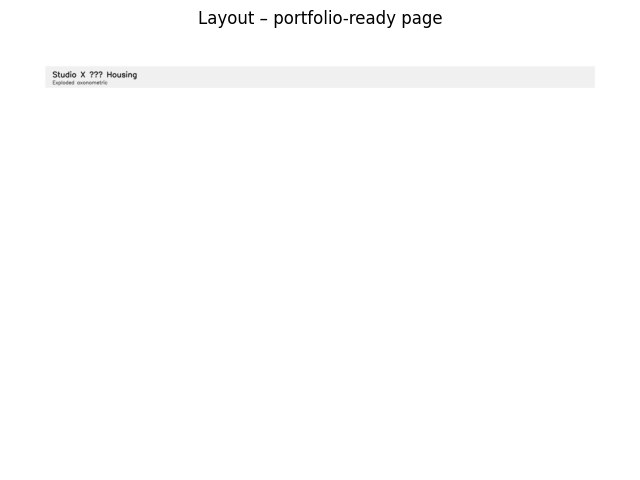

In [ ]:
LAYOUTS = {
    "A3_landscape": {"size": (3508, 2480)},  # px at 300dpi approx
    "A4_portrait": {"size": (2480, 3508)},
    "square": {"size": (2500, 2500)},
    "widescreen": {"size": (3200, 1800)},
}

def place_on_layout(diagram_img, layout_name="A3_landscape", margin=200, title="Project title", subtitle="Diagram type"):
    layout = LAYOUTS.get(layout_name, LAYOUTS["A3_landscape"])
    W, H = layout["size"]
    canvas = np.full((H, W, 3), 255, dtype=np.uint8)

    # Resize diagram to fit
    h, w, _ = diagram_img.shape
    max_w = W - 2 * margin
    max_h = H - 2 * margin - 200
    scale = min(max_w / w, max_h / h)
    new_w, new_h = int(w * scale), int(h * scale)
    resized = cv2.resize(diagram_img, (new_w, new_h), interpolation=cv2.INTER_AREA)

    x0 = (W - new_w) // 2
    y0 = margin + 150
    canvas[y0:y0 + new_h, x0:x0 + new_w] = resized

    # Simple title block
    cv2.rectangle(canvas, (margin, margin), (W - margin, margin + 120), (240, 240, 240), -1)
    cv2.putText(canvas, title, (margin + 40, margin + 60), cv2.FONT_HERSHEY_SIMPLEX, 1.4, (30, 30, 30), 3, cv2.LINE_AA)
    cv2.putText(canvas, subtitle, (margin + 40, margin + 100), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (90, 90, 90), 2, cv2.LINE_AA)

    return canvas

layout_img = place_on_layout(axon_img, layout_name="A3_landscape", title="Studio X – Housing", subtitle="Exploded axonometric")
show(layout_img, title="Layout – portfolio-ready page")

In [ ]:
def save_image(img, filename="diagram_output.png"):
    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(filename, img_bgr)
    files.download(filename)

# Example:
# save_image(layout_img, "axon_layout.png")